# A) This notebook offers a comprehensive tutorial on WE data analysis with minimal user input, using the HDF5 file format generated by Wepy.


### https://adicksonlab.github.io/wepy/_source/tutorials/data_analysis/hdf5_access/README.html

In [ ]:
import os,sys
os.chdir("/home/suman/Shaheerah/Ligand_Unbinding/")
sys.path.append(os.path.abspath("Scripts/"))
sys.path.append(os.path.abspath("Analysis/"))
sys.path.append(os.path.abspath("Systems/"))


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from cycler import cycler

In [3]:
from wepy.hdf5 import WepyHDF5
from wepy.analysis.parents import resampling_panel, parent_panel, net_parent_table, ancestors
from wepy.resampling.decisions.clone_merge import MultiCloneMergeDecision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots


plt.style.use(['science', 'ieee', 'grid'])
plt.rcParams["text.usetex"] = False  # if you don’t want LaTeX
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["DejaVu Serif"]  # fallback
plt.rcParams["figure.dpi"] = 600
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['lines.markeredgecolor'] = 'black'
plt.rcParams.update({'axes.prop_cycle': cycler('color', ['#bc80bd', '#fb8072', '#b3de69', '#fdb462', '#fccde5', '#8dd3c7',
                                    '#ffed6f', '#bebada', '#80b1d3', '#ccebc5', '#d9d9d9'])})

### First load & open the HDF5 file named "wepy.results.h5" with "read" mode. Also provide the time interval between cycles i.e number of MD steps * MD integration time step.

In [215]:
filename = "//home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/final_folding_runs_0.2/simdata_runtest_1_steps50000_cycs10000/wepy.results.h5"
wepy_h5 = WepyHDF5(filename, mode='r')
wepy_h5.open()


### To extract & display the necessary informations from the HDF5 file for convergence check & MFPT calculation, run the following cell. 

In [216]:
if "steps" in filename:
            steps_str = filename.split("steps")[1].split("_")[0]
            delta_t = int(steps_str) * 0.002  # ps
print(f"Delta t: {delta_t} ps")
# Print all the basic informations related to the WE simulations
n_walkers = wepy_h5.num_init_walkers(0)       # Number of walkers
warped_walker_idxs = [i[0] for i in list(wepy_h5.h5['/runs/0/warping/walker_idx'])]   # Warped walker ids
cycle_idxs = np.array(list(wepy_h5.h5['/runs/0/warping/_cycle_idxs']))                # Corresponding ids
w_i = wepy_h5.h5['/runs/0/warping/weight']    # weights of the walkers when they reached the target state for the first time
print(w_i)
w_i = np.array([i[0] for i in w_i])
T_list = cycle_idxs * delta_t * 0.001 * n_walkers  # Convert to ns

# Always close the HDF5 file after operations
wepy_h5.close()


print('Number of walkers:', n_walkers, '\n')
print('Cycle indices when the walkers reach the target:\n', cycle_idxs, '\n')
print('Indices of the walkers who reach the target (warped walkers):\n', warped_walker_idxs, '\n')
print('Weights of the warped walkers:\n', w_i, '\n')
print('Cumulative simulation time points (ns) when walkers reach the target:\n', T_list, '\n')
print(f'For example: Walker {warped_walker_idxs[0]} reached the target at {cycle_idxs[0]}th cycle with weight {w_i[0]}.')

Delta t: 100.0 ps
<HDF5 dataset "weight": shape (37, 1), type "<f8">
Number of walkers: 16 

Cycle indices when the walkers reach the target:
 [ 968 1066 1077 1104 1141 2243 2315 2317 2318 2318 2318 2320 2321 2324
 2327 2334 2334 2336 2337 2337 2338 2338 2339 2340 2341 2342 2343 2348
 2356 2364 2365 2381 2401 2402 2407 2414 2422] 

Indices of the walkers who reach the target (warped walkers):
 [0, 5, 9, 10, 2, 0, 12, 5, 2, 9, 13, 10, 7, 3, 9, 3, 13, 9, 2, 4, 5, 15, 7, 13, 6, 3, 7, 12, 6, 5, 12, 13, 4, 15, 7, 5, 12] 

Weights of the warped walkers:
 [1.07301698e-12 1.08361579e-07 5.71908332e-08 7.14885415e-09
 1.69633412e-08 7.76016966e-04 3.50427707e-04 1.16809236e-04
 3.89364118e-05 3.89364118e-05 1.16809236e-04 9.73410296e-06
 9.73410296e-06 9.73410296e-06 1.62235049e-06 2.70391749e-07
 1.08156700e-07 5.40783498e-08 3.24470099e-06 2.70391749e-07
 3.60522332e-08 3.60522332e-08 5.40783498e-07 5.40783498e-08
 1.08156700e-07 9.01305830e-09 9.01305830e-09 1.08156700e-07
 4.46005782e-03 2.

In [217]:
len(cycle_idxs)

37

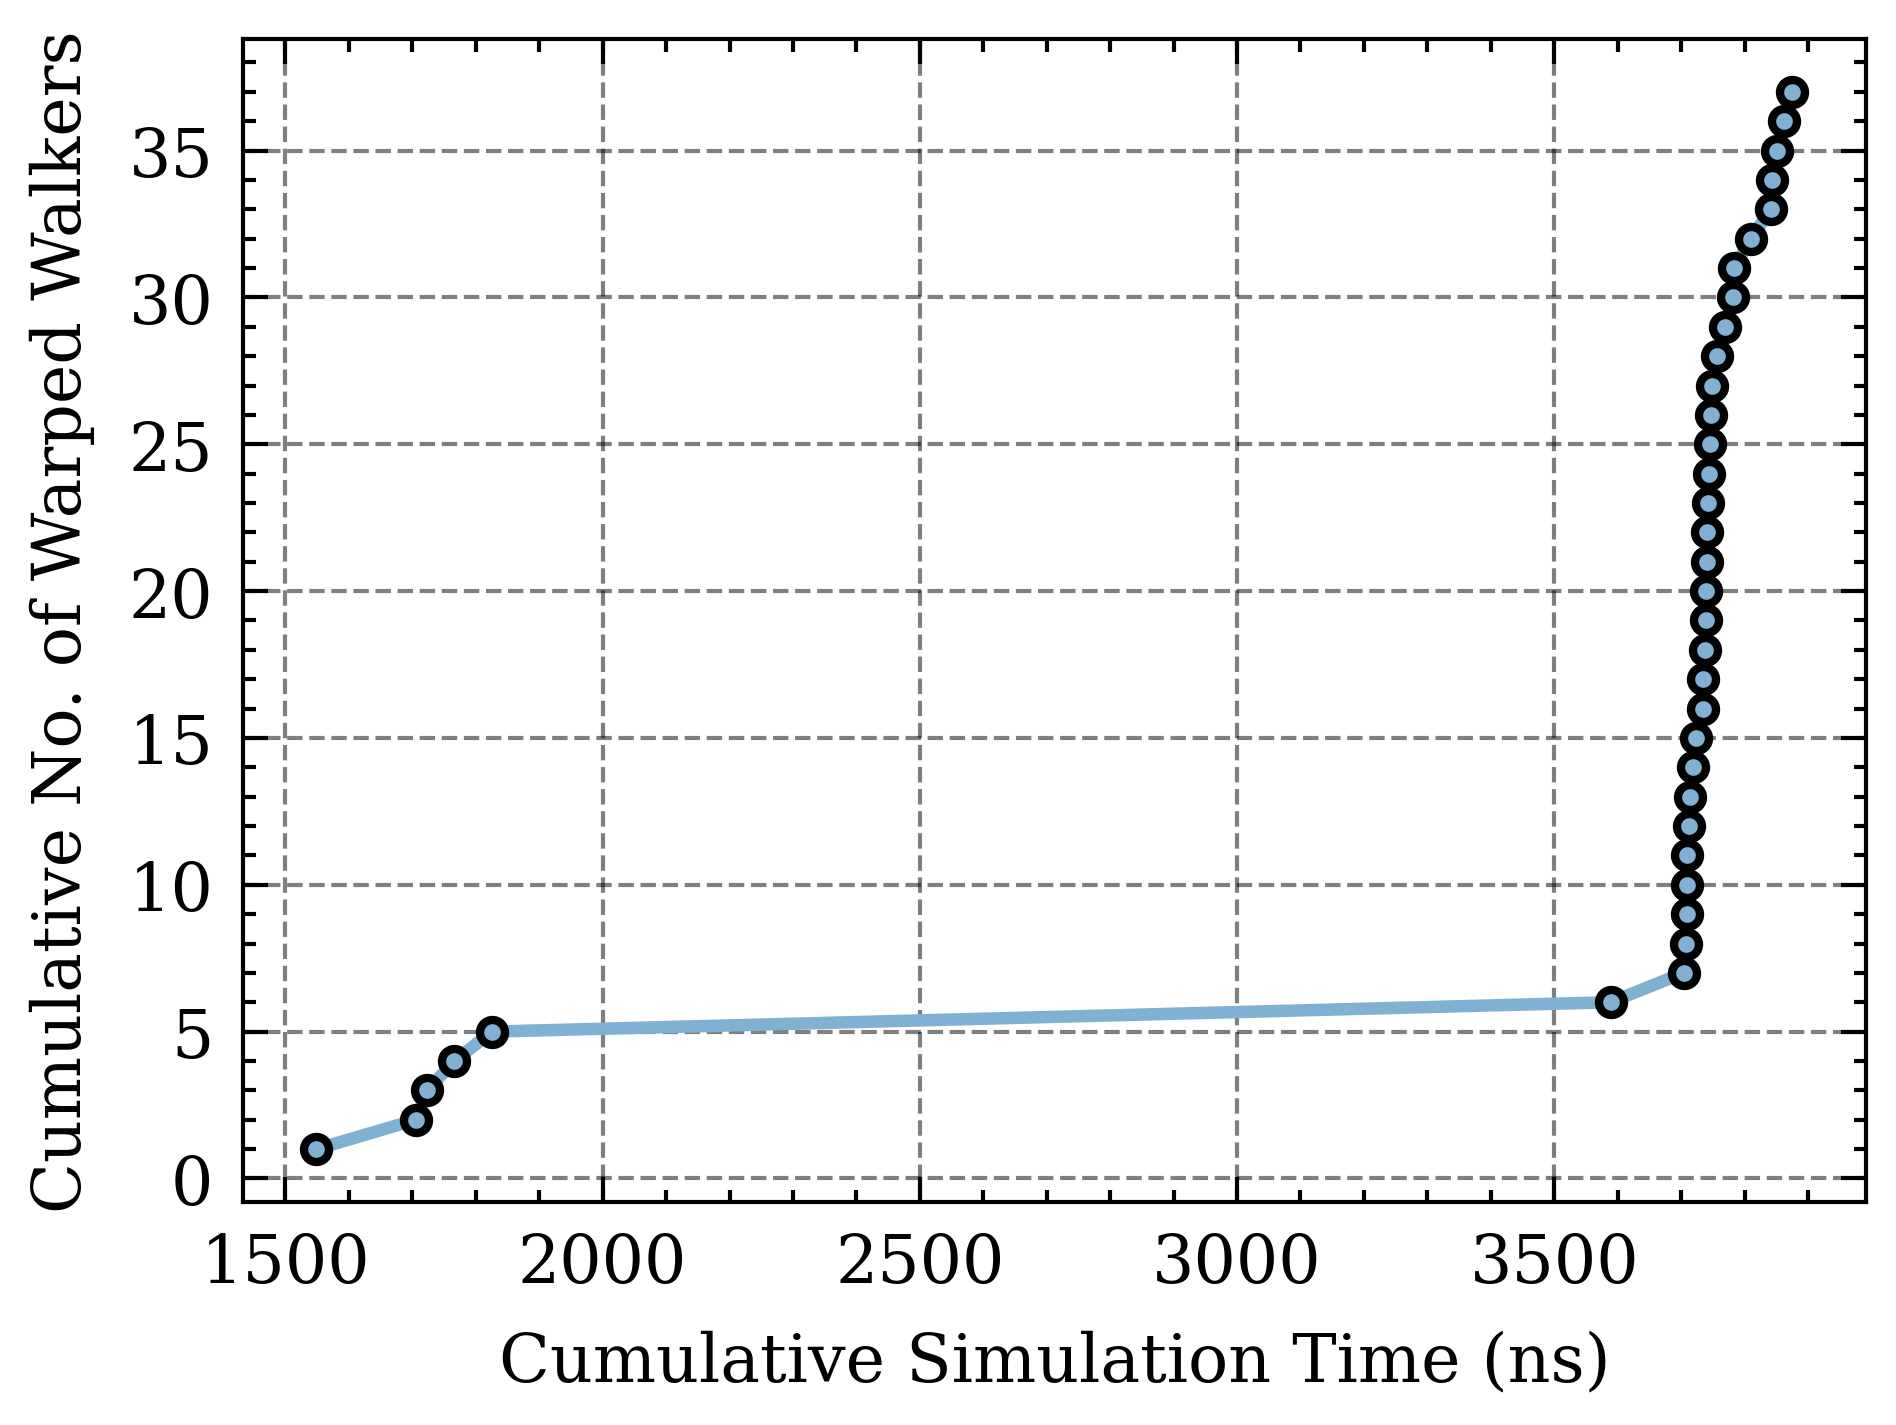

In [218]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming T_list and warped_walker_idxs are already defined as in your code
# Sort the timepoints
sorted_times = np.sort(T_list)
cumulative_counts = np.arange(1, len(sorted_times) + 1)  # 1-based count

# Plot
plt.plot(sorted_times, cumulative_counts, marker='o', linestyle='-', color='#80b1d3',markersize=3, linewidth=1.5)
#print(sorted_times[36], cumulative_counts[36])
plt.xlabel('Cumulative Simulation Time (ns)')
plt.ylabel('Cumulative No. of Warped Walkers')
#plt.title('Cumulative Number of Walkers Reaching Target vs Time', loc='left', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


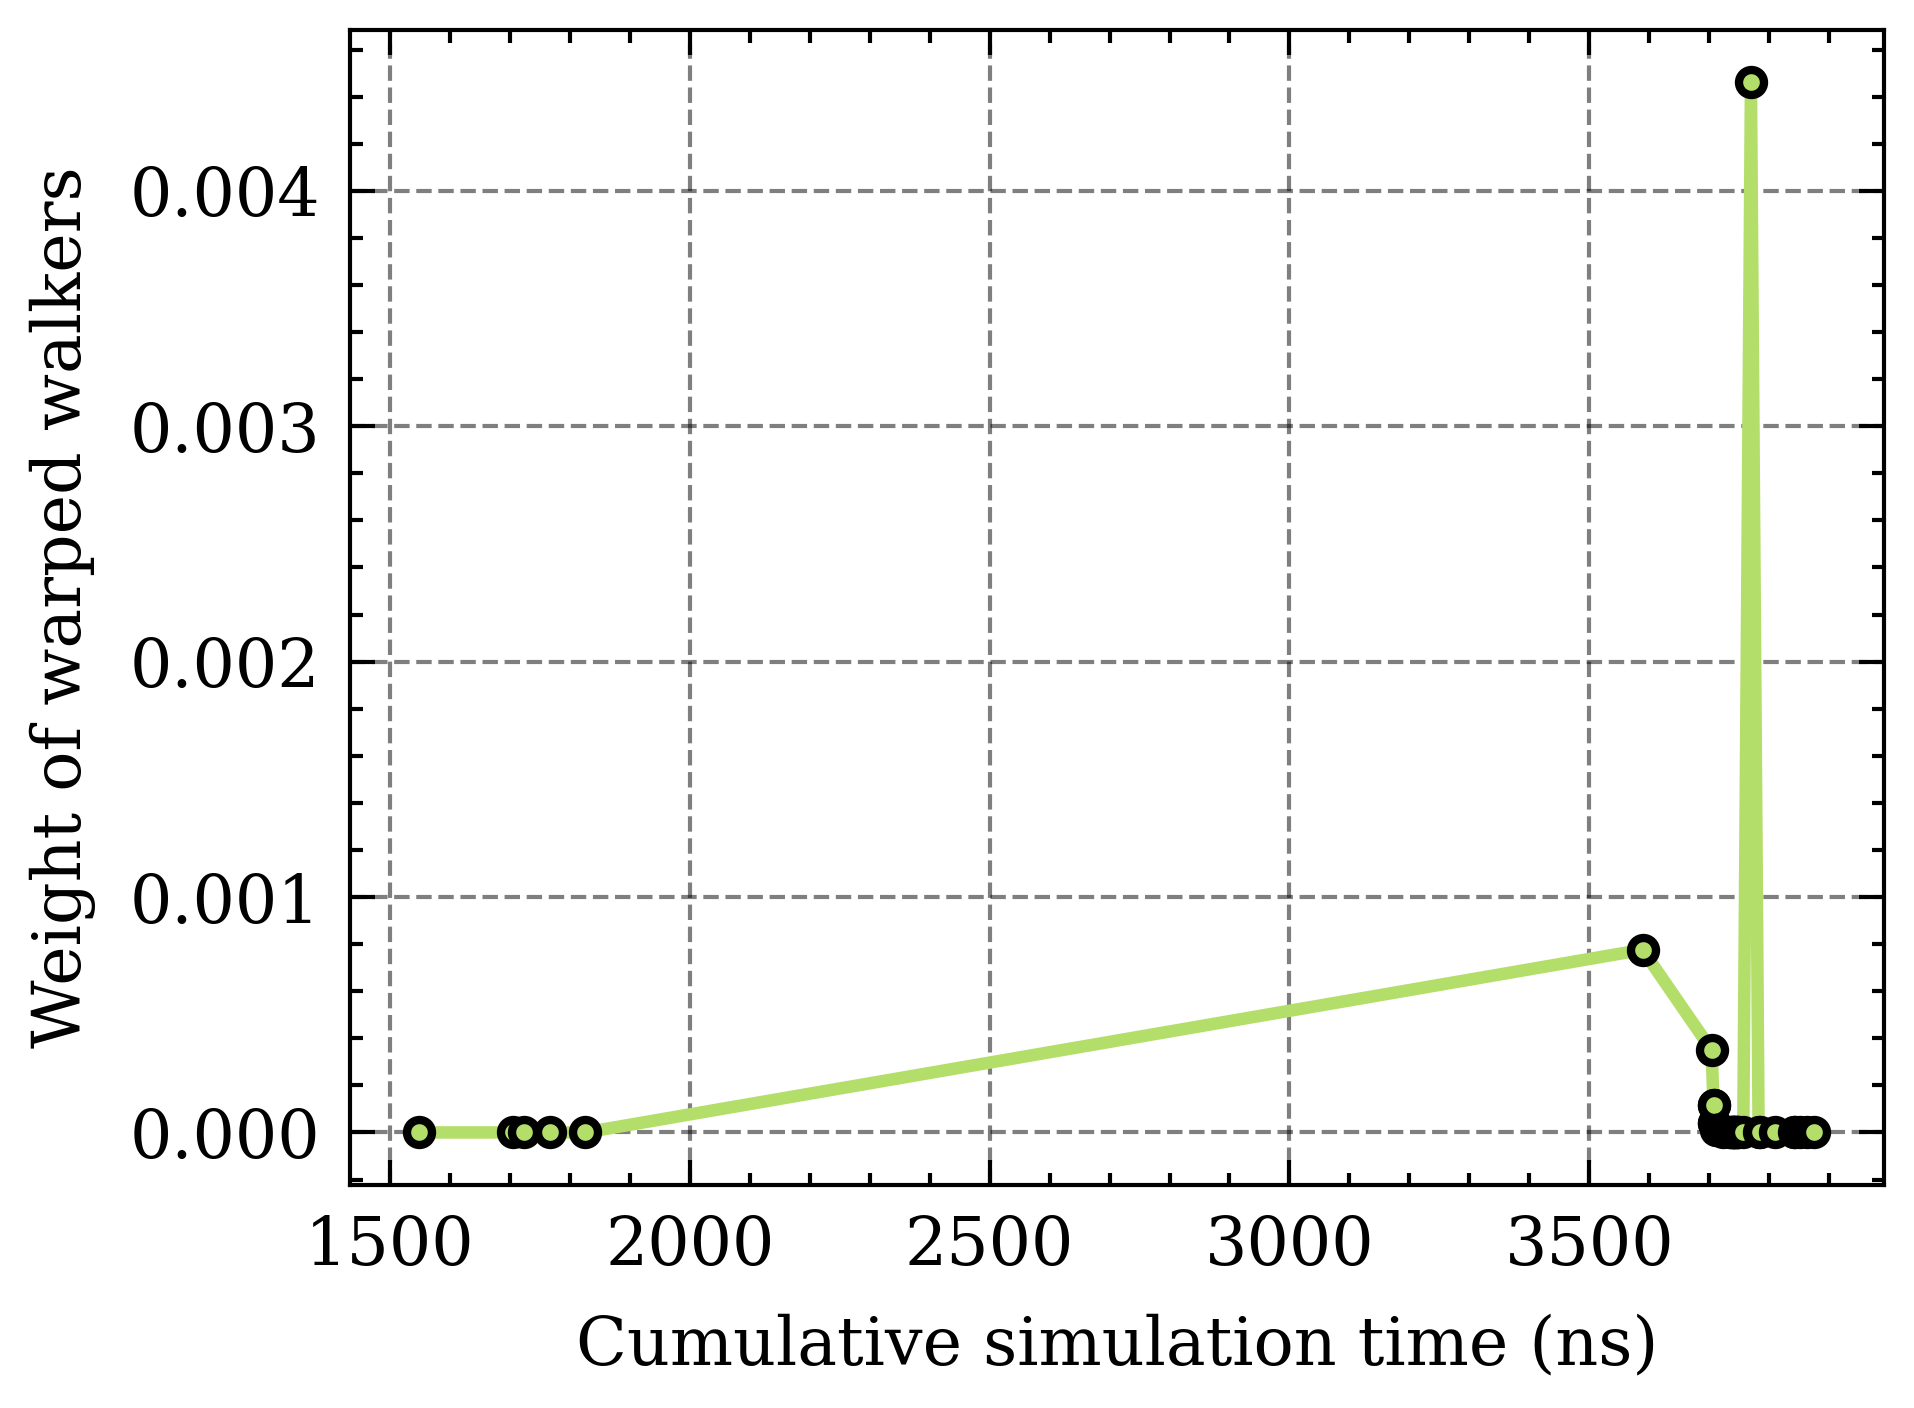

In [219]:
plt.plot(T_list, w_i, 'o', color='#b3de69', markersize=3, linestyle='-', linewidth=1.5)
plt.xlabel("Cumulative simulation time (ns)")
plt.ylabel("Weight of warped walkers")
plt.grid(True, linestyle='--', alpha=0.5)

In [220]:
np.where(w_i > 0.2)

(array([], dtype=int64),)

In [221]:
w_i[:20]

array([1.07301698e-12, 1.08361579e-07, 5.71908332e-08, 7.14885415e-09,
       1.69633412e-08, 7.76016966e-04, 3.50427707e-04, 1.16809236e-04,
       3.89364118e-05, 3.89364118e-05, 1.16809236e-04, 9.73410296e-06,
       9.73410296e-06, 9.73410296e-06, 1.62235049e-06, 2.70391749e-07,
       1.08156700e-07, 5.40783498e-08, 3.24470099e-06, 2.70391749e-07])

### To check convergence, run the following cell. All the necessary informations and the aggregated cumulative probability plot will be printed.

In [222]:
help(np.cumsum)

Help on function cumsum in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See :ref:`ufuncs-output-type` for

In [223]:
w_i, np.cumsum(w_i)

(array([1.07301698e-12, 1.08361579e-07, 5.71908332e-08, 7.14885415e-09,
        1.69633412e-08, 7.76016966e-04, 3.50427707e-04, 1.16809236e-04,
        3.89364118e-05, 3.89364118e-05, 1.16809236e-04, 9.73410296e-06,
        9.73410296e-06, 9.73410296e-06, 1.62235049e-06, 2.70391749e-07,
        1.08156700e-07, 5.40783498e-08, 3.24470099e-06, 2.70391749e-07,
        3.60522332e-08, 3.60522332e-08, 5.40783498e-07, 5.40783498e-08,
        1.08156700e-07, 9.01305830e-09, 9.01305830e-09, 1.08156700e-07,
        4.46005782e-03, 2.81658072e-10, 2.81658072e-10, 1.54911939e-09,
        1.10022684e-12, 1.10022684e-12, 1.10022684e-12, 1.10022684e-12,
        3.71326559e-12]),
 array([1.07301698e-12, 1.08362652e-07, 1.65553485e-07, 1.72702339e-07,
        1.89665680e-07, 7.76206632e-04, 1.12663434e-03, 1.24344357e-03,
        1.28237999e-03, 1.32131640e-03, 1.43812563e-03, 1.44785974e-03,
        1.45759384e-03, 1.46732794e-03, 1.46895029e-03, 1.46922068e-03,
        1.46932884e-03, 1.46938292e-03

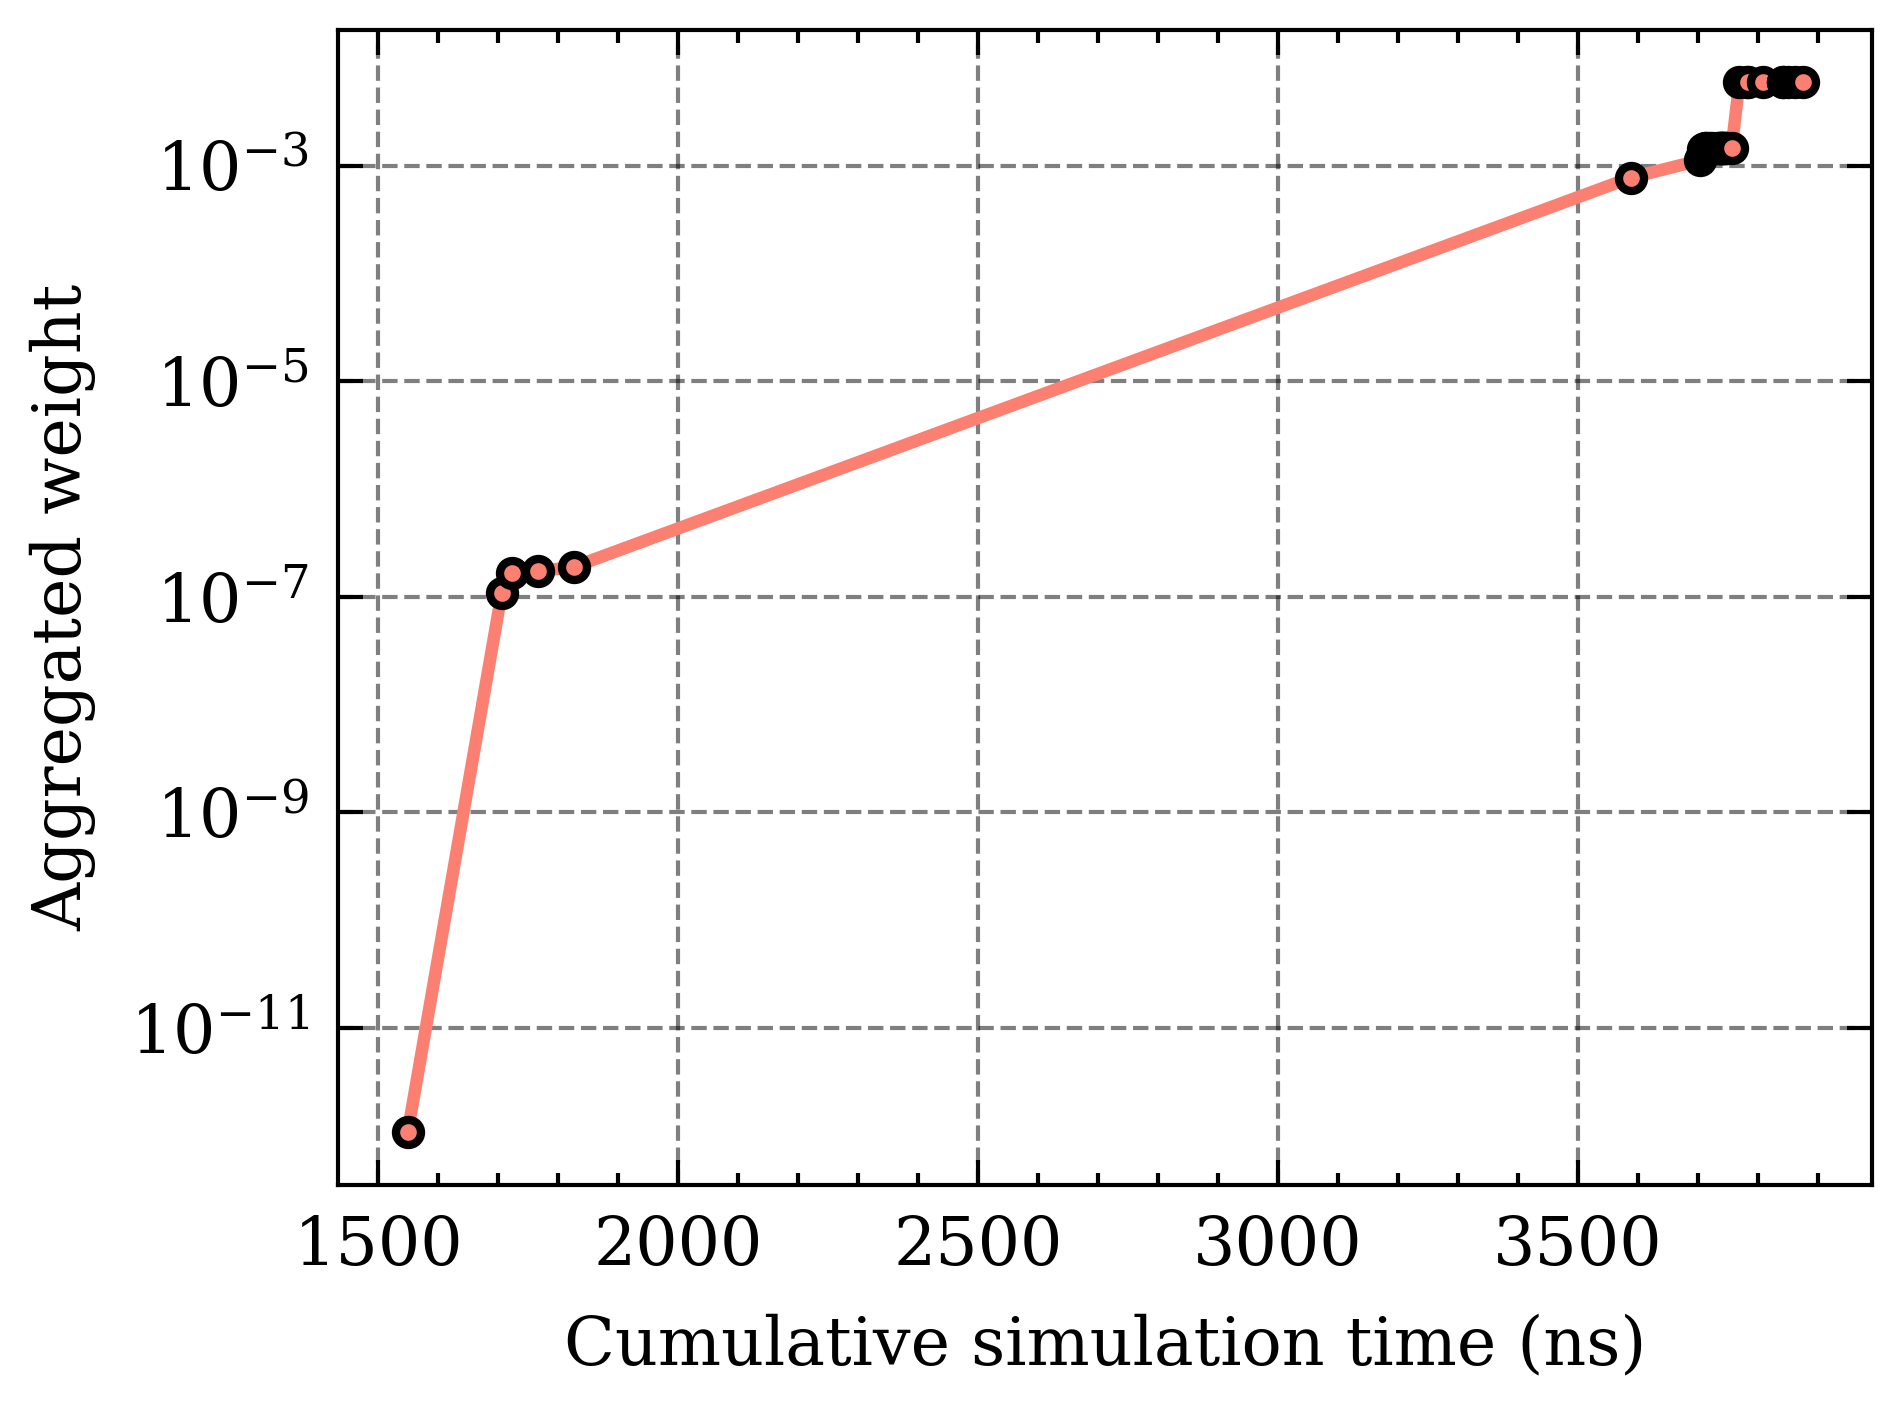

In [224]:
# Plot the data
plt.plot(T_list, np.cumsum(w_i), lw=1.5, marker = 'o',markersize=3, color = '#fb8072')#/len(w_i)
plt.xlabel("Cumulative simulation time (ns)")
plt.ylabel("Aggregated weight")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.5)

### Is the data converged ? If "yes", calculate MFPT by running the following cell.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean first passage time (MFPT) in micro sec:
 [1.44340680e+12 1.57397403e+07 1.04087208e+07 1.02280028e+07
 9.62535762e+06 4.62351113e+03 3.28766830e+03 2.98139785e+03
 2.89212249e+03 2.80689773e+03 2.57891238e+03 2.56378426e+03
 2.54776049e+03 2.53413017e+03 2.53459904e+03 2.54175567e+03
 2.54156857e+03 2.54365282e+03 2.53913477e+03 2.53866865e+03
 2.53969277e+03 2.53963061e+03 2.53978440e+03 2.54077700e+03
 2.54167625e+03 2.54274642e+03 2.54381657e+03 2.54905804e+03
 6.35269760e+02 6.37426843e+02 6.37696452e+02 6.42010509e+02
 6.47403290e+02 6.47672929e+02 6.49021124e+02 6.50908597e+02
 6.53065708e+02] 



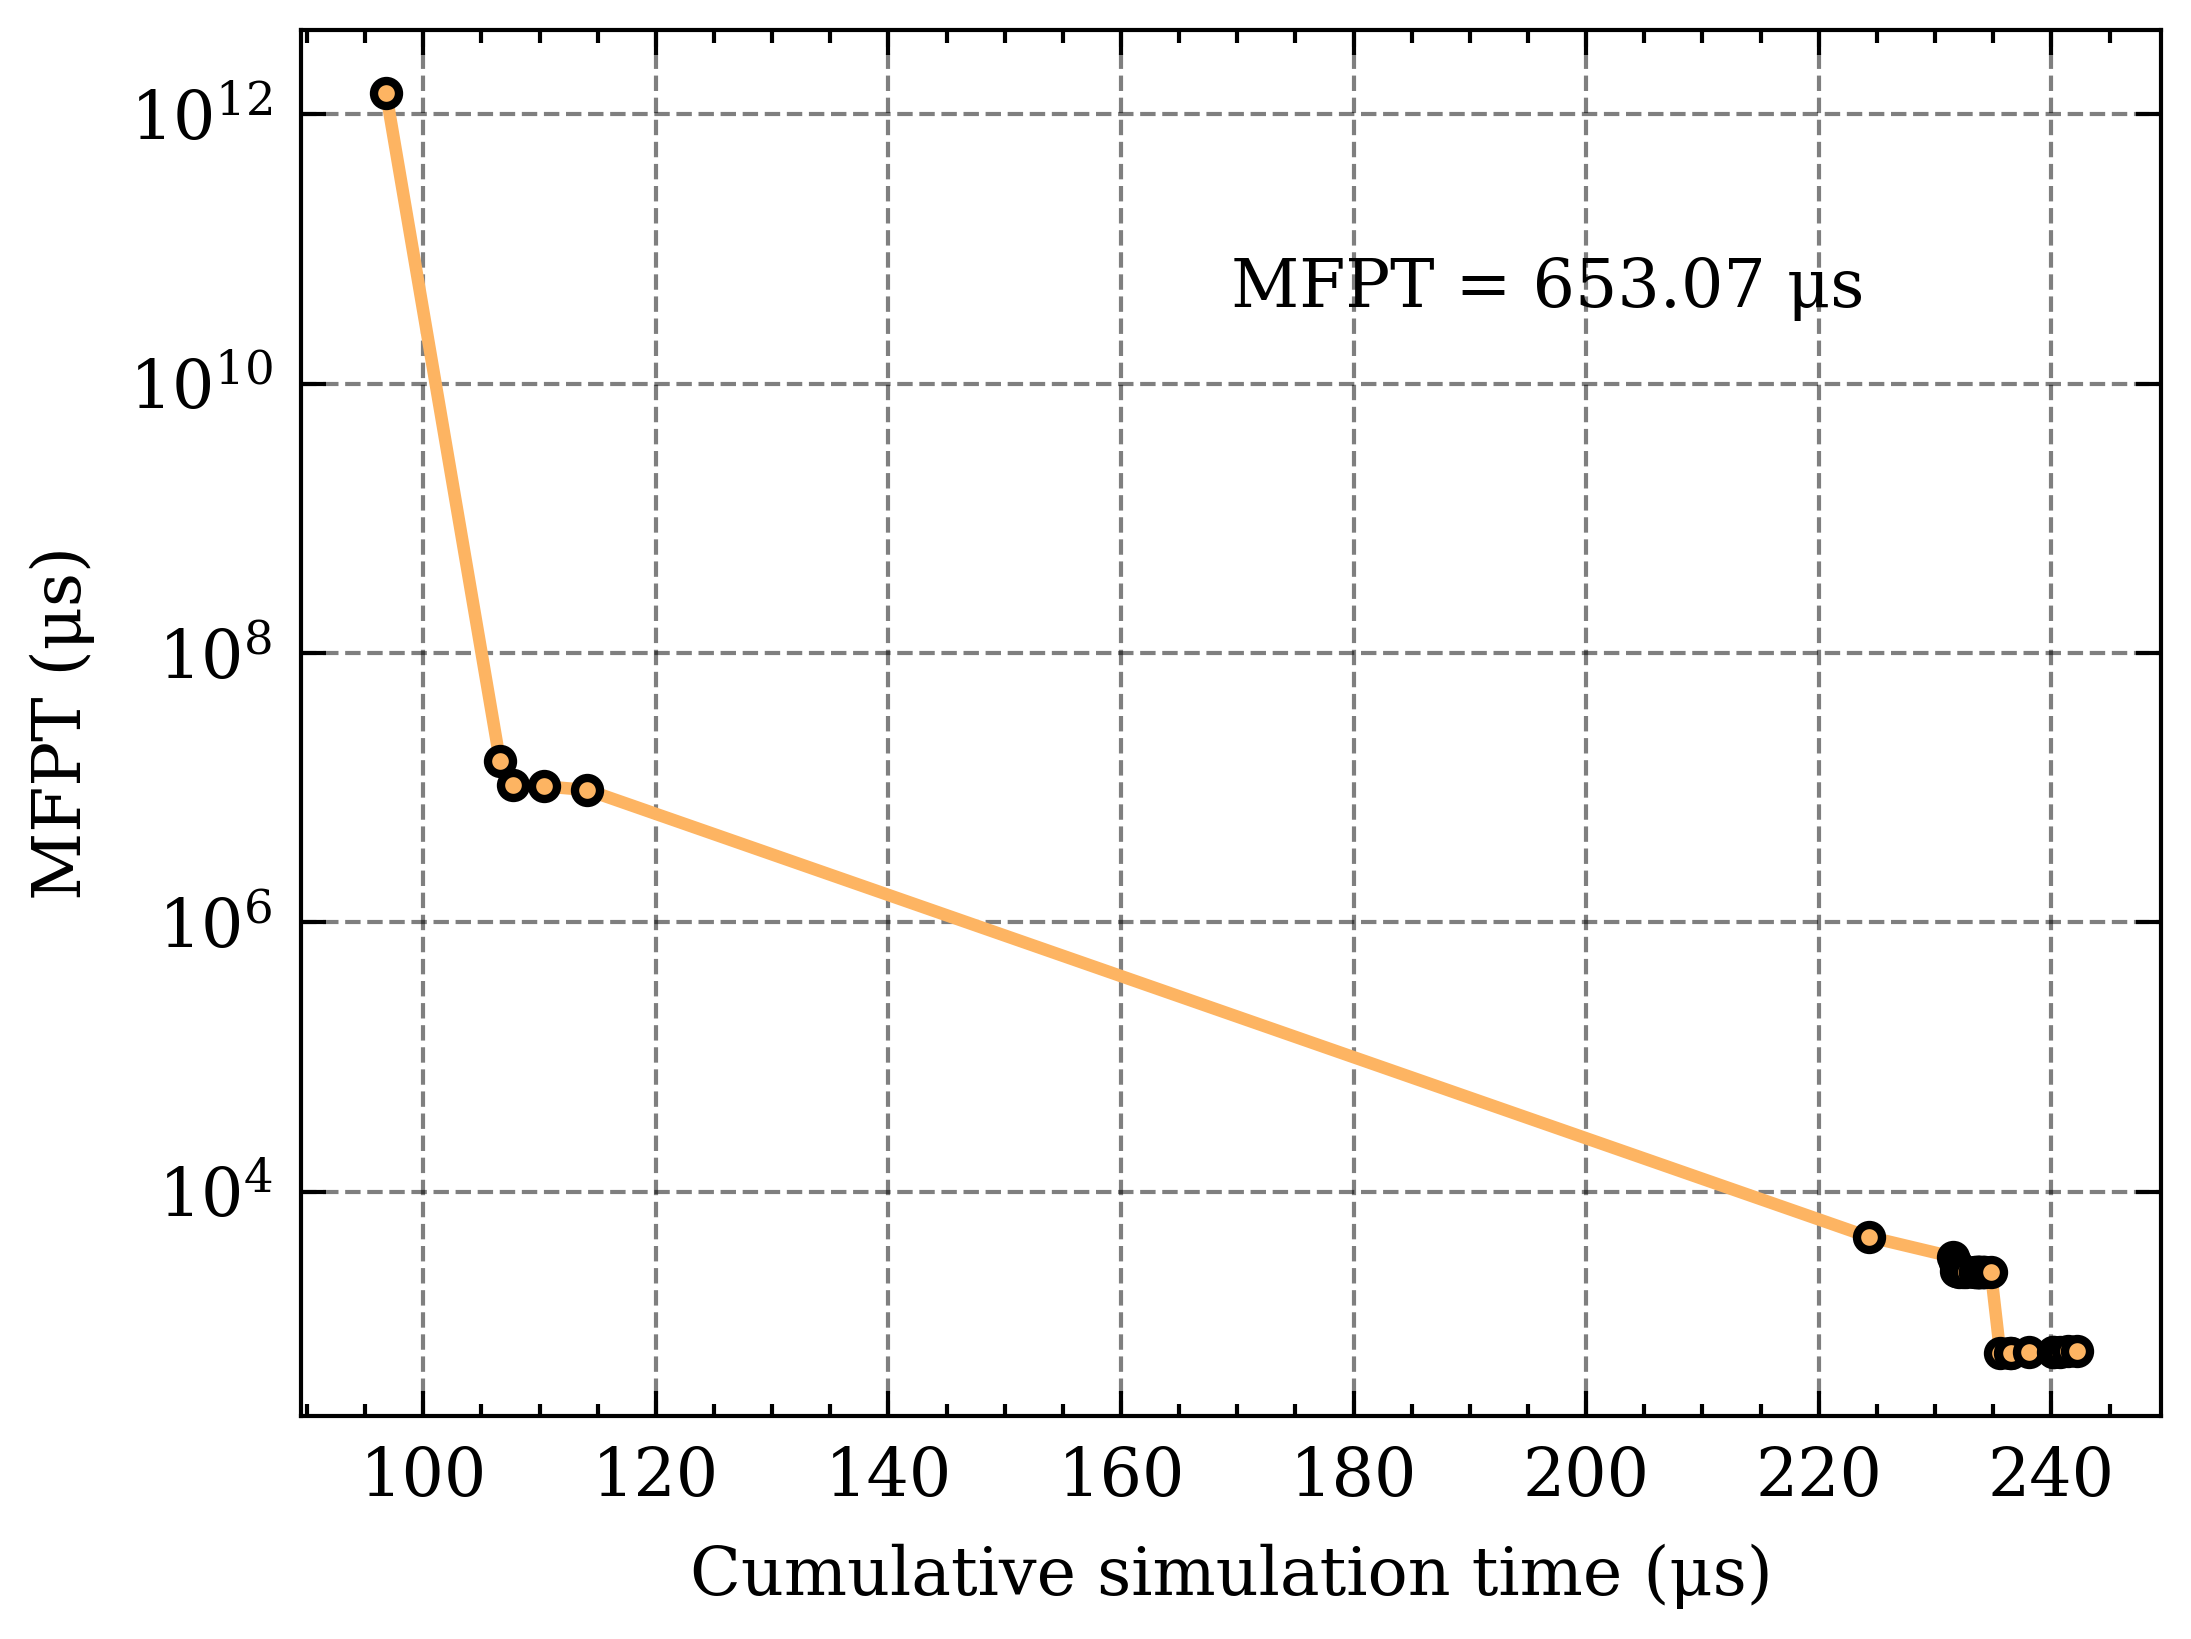

In [225]:
# MFPT calculation according to the eq.2 of the manuscript
mfpt = (T_list/(np.cumsum(w_i)))*0.001     # in micro sec
print('Mean first passage time (MFPT) in micro sec:\n', mfpt[:], '\n')
# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=600)
plt.plot(T_list/n_walkers, mfpt, lw=1.5, marker = 'o', color = '#fdb462',markersize=3)
plt.xlabel("Cumulative simulation time (μs)")
plt.ylabel("MFPT (μs)")
mfpt_ = mfpt[-1]
plt.text(0.5, 0.8, f'MFPT = {mfpt_:.2f} μs', transform=plt.gca().transAxes)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.yscale("log")
plt.grid(True, which='major',axis = 'both' ,linestyle='--', alpha=0.5)


In [ ]:
/run/user/1000/gvfs/sftp:host=172.16.2.58/home/suman/Shaheerah/CoWERA/Systems/Protein_G /Protein_G 

Found 4 runs.
Processing: /home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/final_folding_runs_0.2/simdata_runtest_0_steps50000_cycs10000/wepy.results.h5
Processing: /home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/final_folding_runs_0.2/simdata_runtest_1_steps50000_cycs10000/wepy.results.h5
Processing: /home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/final_folding_runs_0.2/simdata_runtest_2_steps50000_cycs10000/wepy.results.h5
Processing: /home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/final_folding_runs_0.2/simdata_runtest_3_steps50000_cycs10000/wepy.results.h5


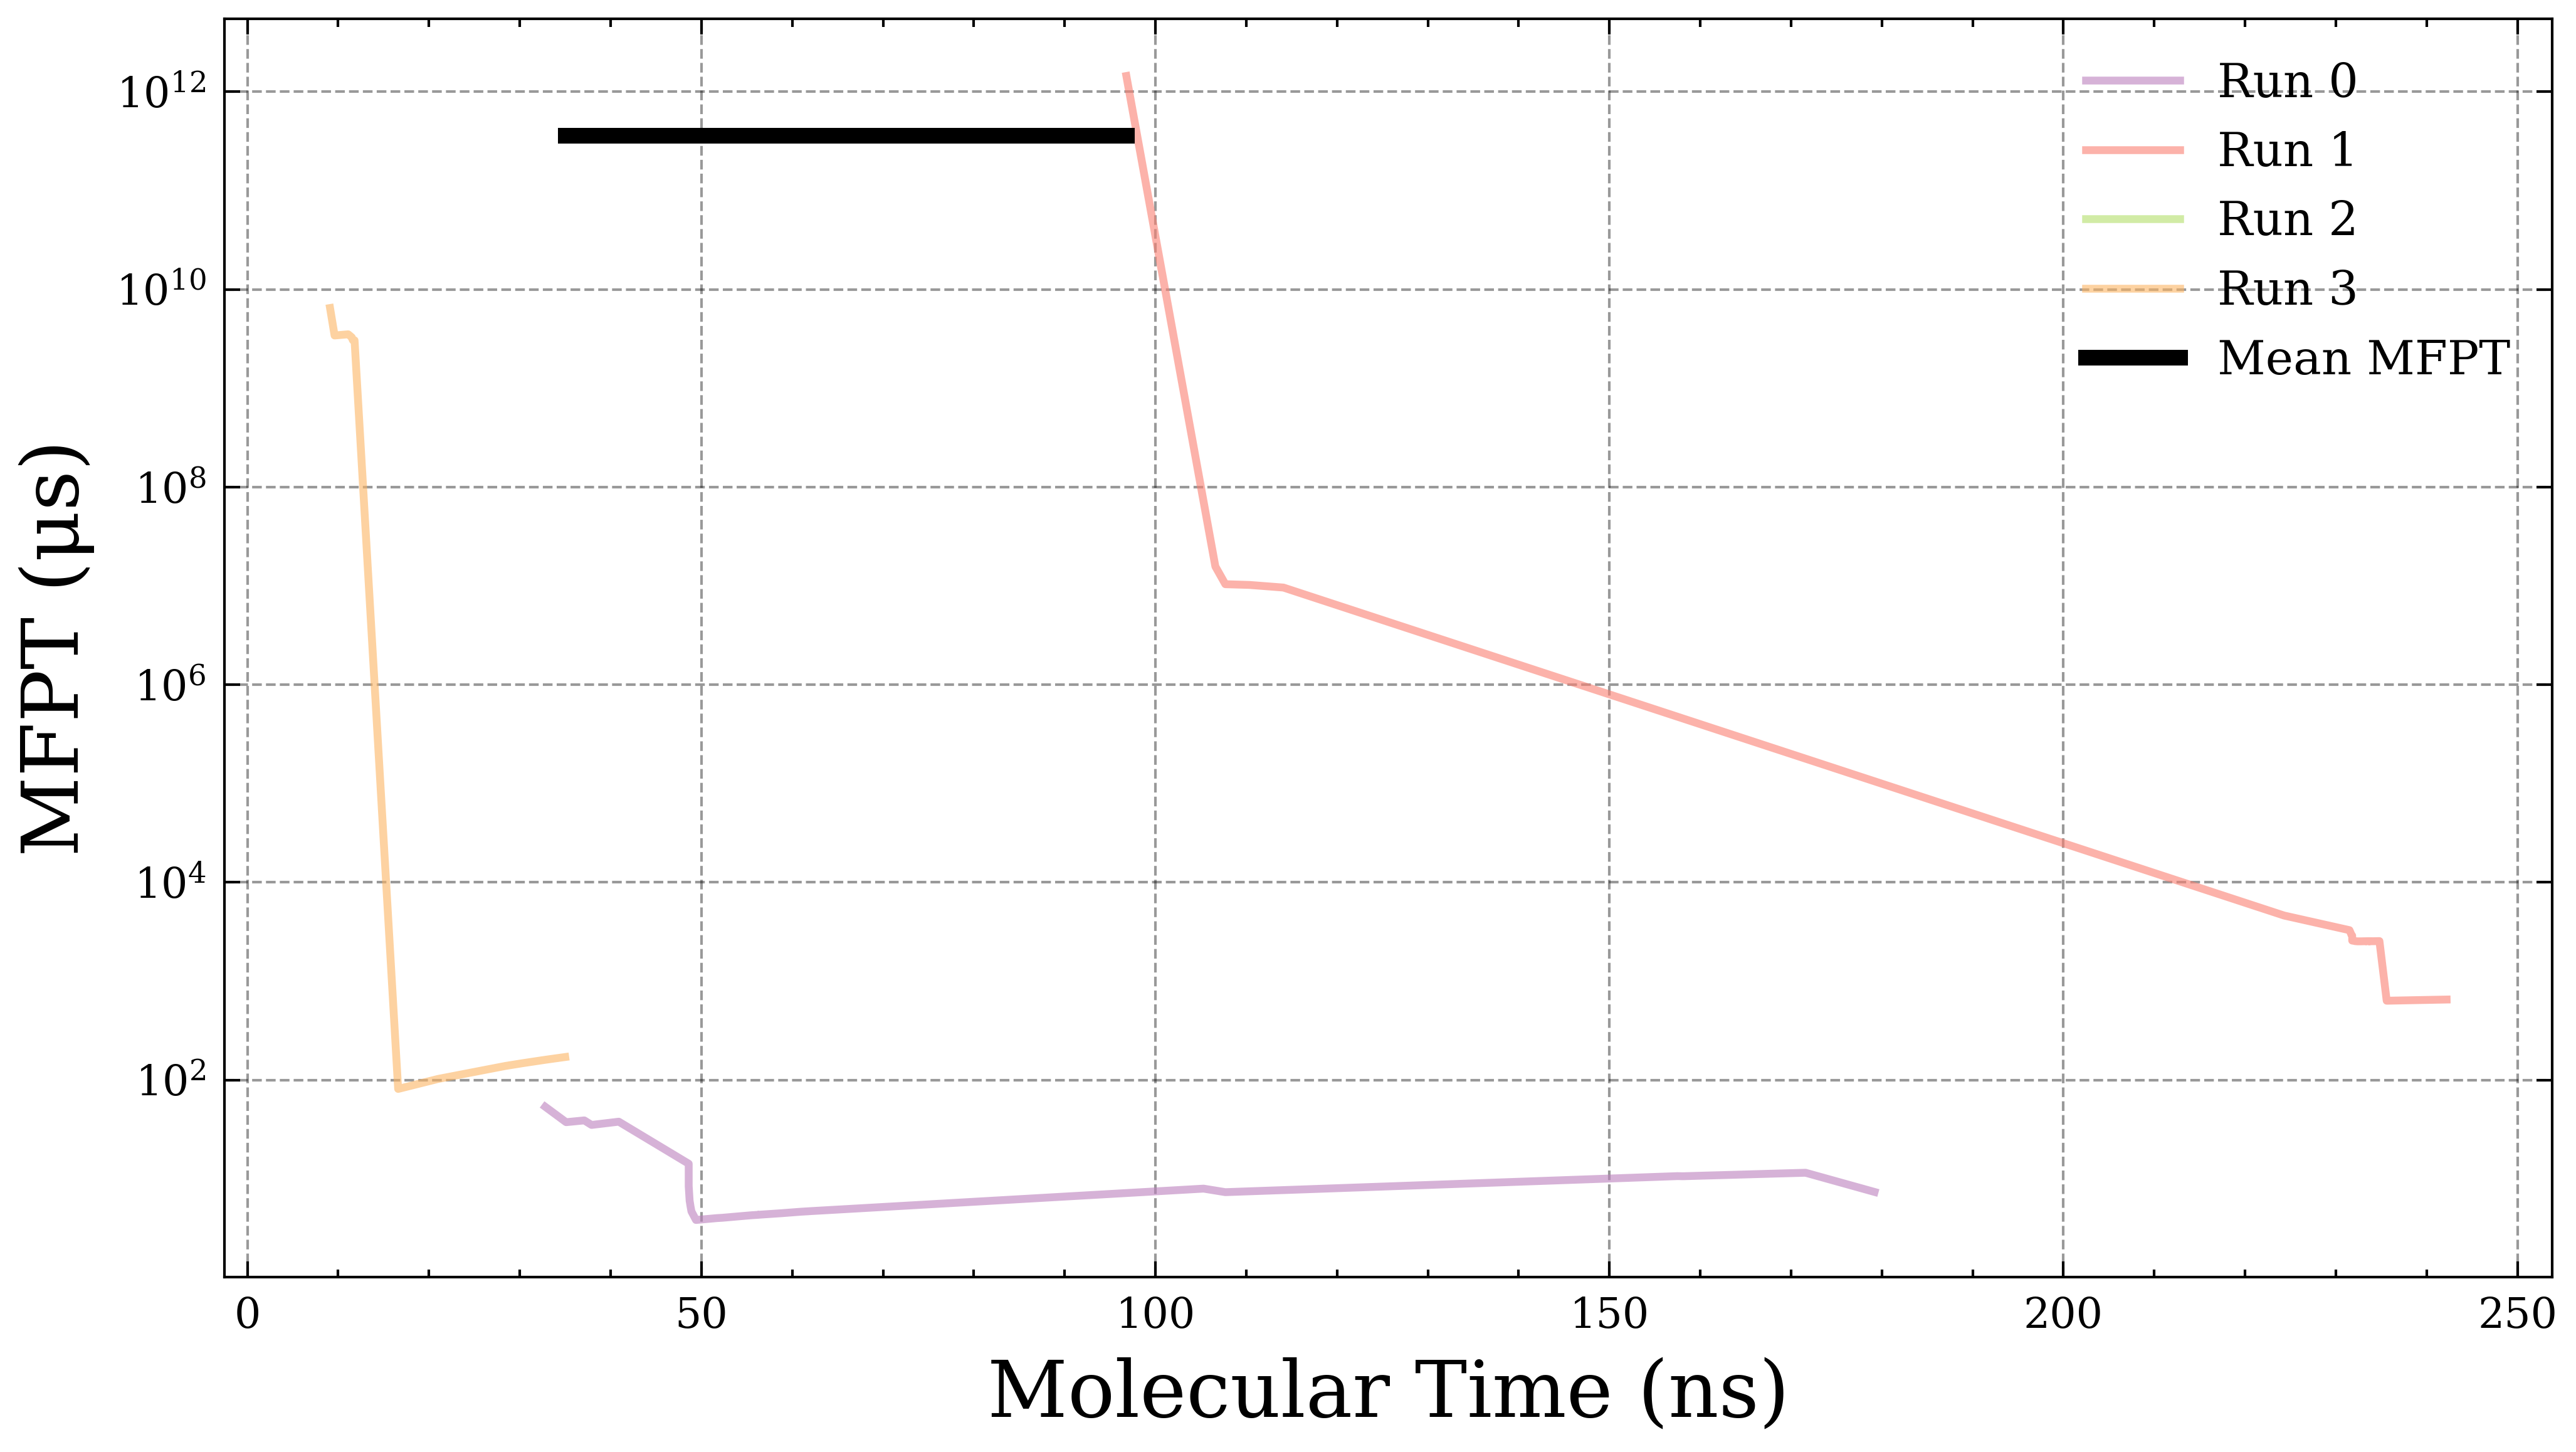

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from wepy.hdf5 import WepyHDF5

# ------------------------------------------------------
# Load all runs automatically
# ------------------------------------------------------
base_folder = '/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/final_folding_runs_0.2'
h5_files = sorted(glob.glob(os.path.join(base_folder, '*/wepy.results.h5')))

print(f"Found {len(h5_files)} runs.")

agg_list   = []
time_list  = []

for path in h5_files:
    print(f"Processing: {path}")

    try:
        wepy_h5 = WepyHDF5(path, mode='r')
        wepy_h5.open()

        # Infer Δt (ps)
        folder = os.path.basename(os.path.dirname(path))
        if "steps" in folder:
            steps_str = folder.split("steps")[1].split("_")[0]
            delta_t = int(steps_str) * 0.002
        else:
            delta_t = 5000 * 0.002

        cycle_idxs = np.array(wepy_h5.h5['/runs/0/warping/_cycle_idxs'])
        weights    = np.array([w[0] for w in wepy_h5.h5['/runs/0/warping/weight']])

        wepy_h5.close()

        # -------- SKIP EMPTY FILES ----------
        if len(cycle_idxs) == 0 or len(weights) == 0:
            print(f"⚠ Skipping {path}: empty cycle or weight data")
            continue

        # Time in ns
        T = cycle_idxs * delta_t * 1e-3
        agg = np.cumsum(weights)

        time_list.append(T)
        agg_list.append(agg)

    except Exception as e:
        print(f"⚠ Skipping {path}: error occurred: {e}")
        continue


# --------------------------------------------------------------------
# Ensure at least ONE valid trajectory was loaded
# --------------------------------------------------------------------
if len(time_list) == 0:
    raise RuntimeError("No valid Wepy trajectories found. All runs were empty?")


# ------------------------------------------------------
# Compute MFPT for each run
# ------------------------------------------------------
eps = 1e-300
n_walkers = 16

MFPT_runs = []

for T, agg in zip(time_list, agg_list):
    agg = np.clip(agg, eps, None)
    MFPT = (T * n_walkers * 1e-3) / agg
    MFPT_runs.append(MFPT)


# ------------------------------------------------------
# Build shared time grid from VALID runs only
# ------------------------------------------------------
T_min = max(t[0] for t in time_list)
T_max = min(t[-1] for t in time_list)

T_common = np.linspace(T_min, T_max, 400)

MFPT_interp = np.zeros((len(MFPT_runs), len(T_common)))

for i in range(len(MFPT_runs)):
    MFPT_interp[i] = np.interp(T_common, time_list[i], MFPT_runs[i])

MFPT_mean = np.mean(MFPT_interp, axis=0)


# ------------------------------------------------------
# Plot
# ------------------------------------------------------
plt.figure(figsize=(7, 4), dpi=600)

# Plot individual runs
for i, MFPT in enumerate(MFPT_runs):
    plt.plot(time_list[i], MFPT, lw=1.5, alpha=0.6, label=f"Run {i}")

# Plot mean MFPT
plt.plot(T_common, MFPT_mean, color='black', lw=3, label='Mean MFPT')

plt.xlabel("Molecular Time (ns)", fontsize=15)
plt.ylabel("MFPT (μs)", fontsize=15)
plt.yscale("log")
plt.grid(True, alpha=0.4)
plt.legend(fontsize=9, frameon=False)
plt.tight_layout()
plt.show()


In [198]:
1800*50000*0.002*0.001*0.001*16

2.88

## Traj analysis

In [199]:
import numpy as np
import scipy as sp
import mdtraj as md
from itertools import combinations


######################################## Best Hummer FNC #################################################

#############################################################################################################


def best_hummer_q(traj, top_file=None, native_file=None, frame_range=None):
    """
    Compute the Best Hummer Q from a trajectory and native structure.

    Parameters:
    - traj: str | md.Trajectory | np.ndarray
        Either a trajectory file path, an md.Trajectory, or a (n_frames, n_atoms, 3) position array
    - top_file: str
        Required if traj is a file path
    - native: str | md.Trajectory
        Native structure as a file path or md.Trajectory
    - native_file: str
        Used only if native is None
    - frame_range: tuple (start, end), optional
        Range of frames to evaluate
    - topology: md.Topology
        Required if traj is a position array

    Returns:
    - q: np.ndarray
        Q values for each frame
    """
    #print(traj,native_file,top_file)
    try:
            # Process trajectory input
        if isinstance(traj, str):
            if top_file is None:
                traj = md.load(traj)
            else:
                traj = md.load(traj, top=top_file)
        elif isinstance(traj, md.Trajectory):
            pass  # already in proper format
        elif isinstance(traj, np.ndarray):
            traj = md.Trajectory(xyz=traj, topology=md.load(top_file).topology)
        else:
            raise TypeError("Unsupported type for traj. Must be str, md.Trajectory, or np.ndarray.")


        native = md.load(native_file)
        #print("Native structure loaded from:", native_file)
        #print("Trajectory loaded from:", traj)
        # Constants
        BETA_CONST = 50  # 1/nm
        LAMBDA_CONST = 1.8
        NATIVE_CUTOFF = 0.45  # nm

        # Compute native contacts from heavy atoms
        heavy = native.topology.select_atom_indices('heavy')
        heavy_pairs = np.array([
            (i, j) for (i, j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - native.topology.atom(j).residue.index) > 3
        ])
        heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
        native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]

        #print("Native contacts ", native_contacts)
        #print("Number of native contacts:", len(native_contacts))

        # Select heavy atoms
        heavy_traj = traj.topology.select_atom_indices('heavy')

        # Generate heavy atom pairs with residue index difference > 3
        heavy_pairs_traj = np.array([
            (i, j) for (i, j) in combinations(heavy_traj, 2)
            if abs(traj.topology.atom(i).residue.index - traj.topology.atom(j).residue.index) > 3
        ])

        # Compute distances ONLY for the last frame
        heavy_distances_traj = md.compute_distances(traj[-1], heavy_pairs_traj)

        # Identify contacts using cutoff
        contacts_traj = heavy_pairs_traj[heavy_distances_traj[0] < NATIVE_CUTOFF]

        # Convert to set of tuples for efficient intersection
        set1 = set(map(tuple, contacts_traj))
        set2 = set(map(tuple, native_contacts))

        # Find common rows
        common_rows = np.array(list(set1 & set2))

        novelty = len(common_rows) / len(native_contacts)


        # Slice frames if requested
        frames = traj[frame_range[0]:frame_range[1]] if frame_range is not None else traj

        # Calculate Q
        r = md.compute_distances(frames, native_contacts)
        r0 = md.compute_distances(native[0], native_contacts)
        q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
        d_range = np.array([0,1])
        #print(q, d_range, novelty)
        return q, d_range

    except Exception as e:
    #    print(f"An error occurred during Hummer Q calculation: {e}")
        return None, None


#############################################################################################################



def RMSD_Backbone(traj, top_file=None, native_file=None):
    """
    Compute backbone RMSD (CA atoms) using MDTraj.

    Parameters
    ----------
    traj : str, np.ndarray, or md.Trajectory
        Trajectory file path, coordinates array, or preloaded trajectory.
    top_file : str
        Topology file (PDB, PSF, etc.). Required for file or array inputs.
    native_file : str
        Reference/native structure file.

    Returns
    -------
    rmsds : np.ndarray
        RMSD values for each frame (aligned on CA atoms).
    drange : np.ndarray
        Array [0, initial RMSD].
    """
    try:
        # Load or convert trajectory
        if isinstance(traj, str):
            if top_file is None:
                traj = md.load(traj)
            else:
                traj = md.load(traj, top=top_file)
        elif isinstance(traj, md.Trajectory):
            pass  # already in correct format
        elif isinstance(traj, np.ndarray):
            if top_file is None:
                raise ValueError("top_file required for NumPy coordinate array.")
            top = md.load(top_file).topology
            traj = md.Trajectory(xyz=traj, topology=top)
        else:
            raise TypeError("traj must be str, md.Trajectory, or np.ndarray.")

        # Load reference structure
        ref = md.load(native_file)

        # Get CA atom indices for alignment and RMSD
        atom_indices = traj.topology.select("name CA")

        # Align trajectory to reference on CA atoms
        traj.superpose(ref, atom_indices=atom_indices)

        # Compute RMSD on CA atoms
        rmsds = md.rmsd(traj, ref, atom_indices=atom_indices)

        drange = np.array([0, rmsds[0]])
        return rmsds, drange

    except Exception as e:
        #print(f"Error in RMSD_Backbone: {e}")
        return None, None

def ResidueMinDistance(traj, top_file=None, native_file=None,
                       resid1=None, resid2=None, resname1=None, resname2=None):
    """
    Compute the minimum CA–CA distance between two residues across trajectory frames.

    Parameters
    ----------
    traj : str, np.ndarray, or md.Trajectory
        Trajectory file path, coordinates array, or preloaded trajectory.
    top_file : str
        Topology file (required for file or array inputs).
    native_file : str
        Reference/native structure file (not required, but kept for consistent interface).
    resid1, resid2 : int, optional
        Residue indices to measure distance between.
    resname1, resname2 : str, optional
        Residue names (e.g., "LYS", "GLU"). Uses the first match found.

    Returns
    -------
    distances : np.ndarray
        Minimum CA–CA distances (nm) for each frame.
    drange : np.ndarray
        Array [0, initial distance].
    """
    try:
        # Load trajectory
        if isinstance(traj, str):
            if top_file is None:
                traj = md.load(traj)
            else:
                traj = md.load(traj, top=top_file)
        elif isinstance(traj, md.Trajectory):
            pass
        elif isinstance(traj, np.ndarray):
            if top_file is None:
                raise ValueError("top_file required for NumPy coordinate array.")
            top = md.load(top_file).topology
            traj = md.Trajectory(xyz=traj, topology=top)
        else:
            raise TypeError("traj must be str, md.Trajectory, or np.ndarray.")

        top = traj.topology

        # Select residue 1
        if resid1 is not None:
            res1 = top.residue(resid1)
        elif resname1 is not None:
            res1 = [r for r in top.residues if r.name == resname1][0]
        else:
            raise ValueError("Must specify resid1 or resname1")

        # Select residue 2
        if resid2 is not None:
            res2 = top.residue(resid2)
        elif resname2 is not None:
            res2 = [r for r in top.residues if r.name == resname2][0]
        else:
            raise ValueError("Must specify resid2 or resname2")

        # Select CA atoms for each residue
        res1_atoms = [a.index for a in res1.atoms]
        res2_atoms = [a.index for a in res2.atoms]

        if len(res1_atoms) == 0 or len(res2_atoms) == 0:
            raise ValueError("Could not find CA atoms for one or both residues.")

        # Print residues used
        print(f"Tracking min distance between {res1} and {res2}")

        # Generate all CA–CA pairs
        pairs = np.array([(i, j) for i in res1_atoms for j in res2_atoms])

        # Compute all distances
        all_distances = md.compute_distances(traj, pairs)

        # Take min across pairs per frame
        distances = np.min(all_distances, axis=1)

        drange = np.array([0, distances[0]])
        return distances, drange

    except Exception as e:
        print(f"Error in ResidueMinDistance: {e}")
        return None, None

def SaltBridgeDistance(traj, top_file=None, native_file=None,
                       resid1=None, resid2=None, resname1=None, resname2=None):
    """
    Track minimum salt bridge distance between two residues across trajectory frames.

    Parameters
    ----------
    traj : str, np.ndarray, or md.Trajectory
        Trajectory file path, coordinates array, or preloaded trajectory.
    top_file : str
        Topology file (required for file or array inputs).
    native_file : str
        Reference/native structure file (not required, kept for consistency).
    resid1, resid2 : int, optional
        Residue indices to check.
    resname1, resname2 : str, optional
        Residue names (e.g., "LYS", "GLU"). Uses the first match found.

    Returns
    -------
    distances : np.ndarray
        Minimum salt bridge distance per frame (nm). If no valid atoms found, returns None.
    drange : np.ndarray
        Array [0, initial distance].
    """
    try:
        # Load trajectory
        if isinstance(traj, str):
            traj = md.load(traj, top=top_file) if top_file else md.load(traj)
        elif isinstance(traj, md.Trajectory):
            pass
        elif isinstance(traj, np.ndarray):
            if top_file is None:
                raise ValueError("top_file required for NumPy coordinate array.")
            top = md.load(top_file).topology
            traj = md.Trajectory(xyz=traj, topology=top)
        else:
            raise TypeError("traj must be str, md.Trajectory, or np.ndarray.")

        top = traj.topology

        # Find residues
        if resid1 is not None:
            res1 = top.residue(resid1)
        elif resname1 is not None:
            res1 = [r for r in top.residues if r.name == resname1][0]
        else:
            raise ValueError("Must specify resid1 or resname1")

        if resid2 is not None:
            res2 = top.residue(resid2)
        elif resname2 is not None:
            res2 = [r for r in top.residues if r.name == resname2][0]
        else:
            raise ValueError("Must specify resid2 or resname2")

        print(f"Tracking salt bridge between {res1} and {res2}")

        # Define charged atom names
        acidic_atoms = {"ASP": ["OD1", "OD2"], "GLU": ["OE1", "OE2"]}
        basic_atoms  = {"LYS": ["NZ"], "ARG": ["NE", "NH1", "NH2"], "HIS": ["ND1", "NE2"]}

        def get_atoms(res, atom_dict):
            return [a.index for a in res.atoms if a.name in atom_dict.get(res.name, [])]

        # Collect atoms for both residues
        res1_atoms = get_atoms(res1, acidic_atoms) + get_atoms(res1, basic_atoms)
        res2_atoms = get_atoms(res2, acidic_atoms) + get_atoms(res2, basic_atoms)

        if len(res1_atoms) == 0 or len(res2_atoms) == 0:
            print("No charged atoms found for salt bridge calculation.")
            return None, None

        # All pairs
        pairs = np.array([(i, j) for i in res1_atoms for j in res2_atoms])

        # Distances
        all_distances = md.compute_distances(traj, pairs)
        distances = np.min(all_distances, axis=1)  # min per frame

        drange = np.array([0, distances[0]])
        return distances, drange

    except Exception as e:
        print(f"Error in SaltBridgeDistance: {e}")
        return None, None

def HelicalContentRatio(traj, top_file=None, native_file=None):
    """
    Compute the ratio of helical content between trajectory frames and native structure.

    Parameters
    ----------
    traj : str, np.ndarray, or md.Trajectory
        Trajectory file path, coordinates array, or preloaded trajectory.
    top_file : str, optional
        Topology file (PDB, PSF, etc.), required for file or array inputs.
    native_file : str
        Native/reference structure file.

    Returns
    -------
    ratios : np.ndarray
        Helical content ratio per frame (frame_helical_count / native_helical_count).
    drange : np.ndarray
        Array [0, ratio_of_first_frame].
    """
    try:
        # Load trajectory
        if isinstance(traj, str):
            traj = md.load(traj, top=top_file) if top_file else md.load(traj)
        elif isinstance(traj, md.Trajectory):
            pass
        elif isinstance(traj, np.ndarray):
            if top_file is None:
                raise ValueError("top_file required for NumPy coordinate array.")
            top = md.load(top_file).topology
            traj = md.Trajectory(xyz=traj, topology=top)
        else:
            raise TypeError("traj must be str, md.Trajectory, or np.ndarray.")

        # Load native structure
        native = md.load(native_file)

        # Assign secondary structure using DSSP
        native_dssp = md.compute_dssp(native, simplified=False)[0]
        traj_dssp = md.compute_dssp(traj, simplified=False)

        # Define helix states: alpha (H), 3-10 (G), pi-helix (I)
        helix_states = {"H", "G", "I"}

        # Count helices
        native_helical_count = np.sum([s in helix_states for s in native_dssp])

        if native_helical_count == 0:
            raise ValueError("Native structure has zero helical content. Cannot compute ratio.")

        traj_helical_counts = np.array([np.sum([s in helix_states for s in frame])
                                        for frame in traj_dssp])

        # Ratios
        ratios = traj_helical_counts / native_helical_count
        drange = np.array([0, ratios[0]])

        return ratios, drange

    except Exception as e:
        print(f"Error in HelicalContentRatio: {e}")
        return None, None


def SASARatio(traj, top_file=None, native_file=None, atom_wise=False):
    """
    Compute the ratio of SASA between trajectory frames and the native structure.

    Parameters
    ----------
    traj : str, np.ndarray, or md.Trajectory
        Trajectory file path, coordinates array, or preloaded trajectory.
    top_file : str, optional
        Topology file (required for file or array inputs).
    native_file : str
        Native/reference structure file.
    atom_wise : bool, default=False
        If True, compute ratio per atom SASA (shape: n_frames x n_atoms).
        If False, compute ratio of total SASA per frame.

    Returns
    -------
    ratios : np.ndarray
        SASA ratios per frame (trajectory SASA / native SASA).
    drange : np.ndarray
        Array [0, ratio_of_first_frame].
    """
    try:
        # Load trajectory
        if isinstance(traj, str):
            traj = md.load(traj, top=top_file) if top_file else md.load(traj)
        elif isinstance(traj, md.Trajectory):
            pass
        elif isinstance(traj, np.ndarray):
            if top_file is None:
                raise ValueError("top_file required for NumPy coordinate array.")
            top = md.load(top_file).topology
            traj = md.Trajectory(xyz=traj, topology=top)
        else:
            raise TypeError("traj must be str, md.Trajectory, or np.ndarray.")

        # Load native structure
        native = md.load(native_file)

        # Compute SASA
        sasa_traj = md.shrake_rupley(traj,mode = "residue")      # (n_frames, n_atoms)
        sasa_native = md.shrake_rupley(native, mode = "residue")  # (1, n_atoms)

        if not atom_wise:
            sasa_traj = sasa_traj.sum(axis=1)       # total per frame
            sasa_native = sasa_native.sum(axis=1)[0]  # total single value
        else:
            sasa_native = sasa_native[0]  # per-atom SASA for native

        # Ratios
        ratios = sasa_traj / sasa_native
        drange = np.array([0, ratios[0]])

        return ratios, drange

    except Exception as e:
        print(f"Error in SASARatio: {e}")
        return None, None



In [ ]:
traj_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folding/simdata_runtest_03_0.1_steps50000_cycs10000/trajectories/productive_traj_16.dcd"
top_file =  "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"
native_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"


In [ ]:
rmsd,drange= RMSD_Backbone(traj_file, top_file=top_file, native_file=native_file)
q,drange = best_hummer_q(traj_file, top_file=top_file, native_file=native_file)
distances, drange = ResidueMinDistance(traj_file, top_file=top_file,
                                    native_file=native_file,resid1=8, resid2=15)
# Between Asp and Lys (by resid index)
sb, drange = SaltBridgeDistance(traj_file, top_file=top_file,
                                    native_file=native_file,
                                       resid1=8, resid2=15)
h,drange = HelicalContentRatio(traj_file, top_file=top_file, native_file=native_file)

In [ ]:

#sasa,drange = SASARatio(traj_file, top_file=top_file, native_file=native_file)

In [ ]:
rmsd,q

In [ ]:
np.mean(q[-10:])

In [ ]:
import ruptures as rpt
algo = rpt.Pelt(model="l2").fit(q)
changes = np.array(algo.predict(pen=0.1))  # Guaranteed to have at least one element
# Subtract n_d from all except the last change point
change_points = np.concatenate(([1], changes[:-1] - 10, changes[-1:]))

In [ ]:
cp = change_points * 0.002 * 5000
print(cp)

In [ ]:
plt.figure(figsize=(10, 3), dpi=600)
plt.plot( (np.array(range(int(len(rmsd))))*delta_t*0.0001*n_walkers),rmsd, linewidth=2.5, marker='o', color='#fb8072',markersize=4)
plt.xlim(0, (len(rmsd)*0.0001*n_walkers*delta_t))
# Reference line (optional contact cutoff, e.g., 0.45 nm)
plt.axhline(0.2, color='r', linestyle='--', linewidth=1.2, alpha=0.7)
plt.ylabel(r'$\mathbf{RMSD}$', fontsize=15)
plt.xlabel(r'$\mathbf{ns}$', fontsize=15)

In [ ]:
plt.figure(figsize=(10, 3), dpi=600)
plt.plot( (np.array(range(int(len(q))))*0.0001*n_walkers) ,q, linewidth=2.5, marker='o', color='#b3de69',markersize=4)
plt.xlim(0, len(q)*0.0001*n_walkers*delta_t)
# Reference line (optional contact cutoff, e.g., 0.45 nm)
plt.axhline(0.8, color='r', linestyle='--', linewidth=1.2, alpha=0.7)
plt.ylabel(r'$\mathbf{Q}$', fontsize=15)
plt.xlabel(r'$\mathbf{ns}$', fontsize=15)

In [ ]:
# Suppose you already computed:
# distances, drange = ResidueMinDistance(...)
# where distances is per-frame min CA–CA distance in nm

plt.figure(figsize=(10, 3), dpi=600)

time_axis = np.arange(len(distances)) *delta_t*0.0001*n_walkers  # convert to ns

plt.plot(time_axis, distances,
         linewidth=2.5,
         marker='o', markersize=4,
         color='#80b1d3', alpha=0.9)

# Axes labels
plt.ylabel(r'$\mathbf{Min Distance\ (nm)}$', fontsize=15)
plt.xlabel(r'$\mathbf{Time\ (ns)}$', fontsize=15)

# Limits and grid
plt.xlim(0, time_axis[-1])
plt.ylim(0, np.max(distances) * 1.1)  # pad y-axis a little
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Reference line (optional contact cutoff, e.g., 0.45 nm)
plt.axhline(0.3, color='r', linestyle='--', linewidth=1.2, alpha=0.7)


plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 3), dpi=600)

time_axis = np.arange(len(distances)) * delta_t *0.0001*n_walkers  # convert to ns

plt.plot(time_axis, sb,
         linewidth=2.5,
         marker='o', markersize=4,
         color='#fdb462', alpha=0.9)

# Axes labels
plt.ylabel(r'$\mathbf{Salt Bridge\ (nm)}$', fontsize=15)
plt.xlabel(r'$\mathbf{Time\ (ns)}$', fontsize=15)

# Limits and grid
plt.xlim(0, time_axis[-1])
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Reference line (optional contact cutoff, e.g., 0.45 nm)
plt.axhline(0.3, color='r', linestyle='--', linewidth=1.2, alpha=0.7)


plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 3), dpi=600)
plt.plot( (np.array(range(int(len(sasa))))*delta_t*0.0001*n_walkers),sasa, linewidth=2.5, marker='o', color='#fb8072',markersize=4)
plt.xlim(0, (len(sasa)*delta_t*0.0001*
             n_walkers))
plt.ylabel(r'$\mathbf{SASA\ residue wise}$', fontsize=15)
plt.xlabel(r'$\mathbf{ns}$', fontsize=15)

In [ ]:
plt.figure(figsize=(10, 3), dpi=600)
plt.plot( (np.array(range(int(len(h))))*delta_t*0.0001*n_walkers),h, linewidth=2.5, marker='o', color='#fb8072',markersize=4)
plt.xlim(0, (len(h)*delta_t*0.0001*
             n_walkers))
# Reference line (optional contact cutoff, e.g., 0.45 nm)
plt.ylim(0,1
         )
plt.axhline(0.2, color='r', linestyle='--', linewidth=1.2, alpha=0.7)
plt.ylabel(r'$\mathbf{Helical\ content\ ratio}$', fontsize=15)
plt.xlabel(r'$\mathbf{ns}$', fontsize=15)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def PlotChunkedMean(data, chunk_size=10, ylabel="Mean Q"):
    """
    Slice an array into chunks and plot the mean of each chunk.

    Parameters
    ----------
    data : np.ndarray
        1D array of values (e.g., Q from best_hummer_q).
    chunk_size : int, default=10
        Number of frames per chunk.
    ylabel : str, default="Mean Q"
        Label for the y-axis.

    Returns
    -------
    means : np.ndarray
        Mean values per chunk.
    """
    # Number of complete chunks
    n_chunks = len(data) // chunk_size

    # Slice into chunks
    chunks = data[:n_chunks * chunk_size].reshape(n_chunks, chunk_size)

    # Compute means
    means = np.mean(chunks, axis=1)

    # Plot
    plt.figure(figsize=(7, 4))
    plt.plot(range(len(means)), means, marker="o", lw=1.5)
    plt.xlabel(f"Chunk index (size={chunk_size})")
    plt.ylabel(ylabel)
    plt.title(f"Mean values per {chunk_size}-frame chunk")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return means


In [ ]:
q_means = PlotChunkedMean(q, chunk_size=10, ylabel="Mean Q")


In [ ]:
import glob
import numpy as np

def CollectTrajByQCutoff(traj_files, top_file, native_file, chunk_size=10, q_cutoff=0.5):
    """
    Collect trajectory indices where chunked mean Q reaches a cutoff.

    Parameters
    ----------
    traj_files : list of str
        List of trajectory file paths (.dcd).
    top_file : str
        Topology file path.
    native_file : str
        Native structure file path.
    chunk_size : int, default=10
        Size of frame chunks for computing mean Q.
    q_cutoff : float, default=0.5
        Threshold for mean Q.

    Returns
    -------
    good_idxs : list of int
        Indices of trajectories where q_mean >= q_cutoff in at least one chunk.
    q_means_list : list of np.ndarray
        List of mean Q arrays for each trajectory.
    """
    good_idxs = []
    q_means_list = []

    for idx, traj_file in enumerate(traj_files):
        # Compute Q
        q, _ = best_hummer_q(traj_file, top_file=top_file, native_file=native_file)
        if q is None:
            continue

        # Chunk into means
        n_chunks = len(q) // chunk_size
        if n_chunks == 0:
            continue
        q_chunks = q[:n_chunks * chunk_size].reshape(n_chunks, chunk_size)
        q_means = np.mean(q_chunks, axis=1)
        q_means_list.append(q_means)

        # Check if any chunk reaches cutoff
        if np.any(q_means >= q_cutoff):
            good_idxs.append(idx)

    return good_idxs, q_means_list


In [ ]:
base_folder = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folding/simdata_runtest_02_0.2_steps50000_cycs10000/trajectories"
# Collect all trajectories
traj_files = sorted(glob.glob(f"{base_folder}/productive_traj_*.dcd"))

# Get trajectories where Q exceeds cutoff
good_idxs, q_means_list = CollectTrajByQCutoff(
    traj_files,
    top_file=top_file,
    native_file=native_file,
    chunk_size=10,
    q_cutoff=0.8
)

print("Trajectories passing cutoff:", good_idxs)

In [ ]:
len(good_idxs)

In [ ]:
mfpt = (T_list[good_idxs]/(np.cumsum(w_i[good_idxs])))*0.001      # in micro sec

In [ ]:
# MFPT calculation according to the eq.2 of the manuscript
print('Mean first passage time (MFPT) in micro sec:\n', mfpt[:], '\n')
# Plot
fig, ax = plt.subplots(figsize=(5, 3), dpi=600)
ax.plot(T_list[good_idxs], mfpt, lw=3.5, marker = 'o', color = '#fdb462')#/len(w_i)

ax.set_ylabel(r'$\mathbf{MFPT \;(\mu s)}$', fontsize=15)
ax.set_xlabel(r'$\mathbf{Total\;simulation\;time\;(ns)}$', fontsize=15)
mfpt_ = mfpt[-1]
ax.text(0.6, 0.8, f'MFPT = {mfpt_:.2f} $\mu$s', transform=ax.transAxes, fontsize=12)
ax.legend(loc='upper right', fontsize=10, frameon=False)
ax.set_yscale("log")
ax.grid(True, linestyle='--', alpha=0.5)

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm   # progress bar

# Paths
base_folder = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folding/simdata_runtest_02_steps50000_cycs10000/trajectories"
top_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"
native_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"

# Parameters
delta_t = 1.0  # ps per frame (change if needed)

# Collect all trajectories
traj_files = sorted(glob.glob(f"{base_folder}/productive_traj_*.dcd"))

# Storage
rmsd_list = []
q_list = []
time_list = []

# Process each trajectory with progress bar
for traj_file in tqdm(traj_files, desc="Processing trajectories"):
    rmsd, _ = RMSD_Backbone(traj_file, top_file=top_file, native_file=native_file)
    q, _ = best_hummer_q(traj_file, top_file=top_file, native_file=native_file)

    time = np.arange(len(rmsd)) * delta_t * 0.001  # ns

    rmsd_list.append(rmsd)
    q_list.append(q)
    time_list.append(time)



In [ ]:
# ---- Plotting ----
fig, axes = plt.subplots(2, 1, figsize=(10, 10), dpi=600, sharex=True)

# RMSD
for i, rmsd in enumerate(rmsd_list):
    axes[0].plot(time_list[i], rmsd, linewidth=1.5,
                 label=traj_files[i].split("/")[-1])
axes[0].set_ylabel(r'$\mathbf{RMSD}\ in\ nm$', fontsize=15)
axes[0].axhline(0.2,c = 'r')
#axes[0].legend(fontsize=6, loc="upper right")

# Q
for i, q in enumerate(q_list):
    axes[1].plot(time_list[i], q, linewidth=1.5,
                 label=traj_files[i].split("/")[-1])
axes[1].set_ylabel(r'$\mathbf{Q}$', fontsize=15)
axes[1].set_xlabel(r'$\mathbf{Time\ (ns)}$', fontsize=15)
axes[1].axhline(0.8,c = 'r')
#axes[1].legend(fontsize=6, loc="upper right")

plt.tight_layout()
#plt.xlim(0, 4)  # Adjust x-axis limit
plt.show()


## Resampling event

In [ ]:
############# User defined part #################

walker_id =  6
cycle_id =  31

#################################################



wepy_h5.open()
output_file = f'cycle{cycle_id}_walker{walker_id}_productive_traj.xtc'

all_ancestors = []
mod_ances = []

run_idx = 0

# Resampling record has information of cloning/merging/squashing/keeping
resamp_rec = wepy_h5.resampling_records([run_idx])
resamp_panel = resampling_panel(resamp_rec)
par_panel = parent_panel(MultiCloneMergeDecision, resamp_panel)
net_par_table = net_parent_table(par_panel)

ances = ancestors(net_par_table, cycle_id, walker_id)
for element in ances:
    mod_ances.append([run_idx, element[0], element[1]])

all_ancestors.append(mod_ances)

# Making trajectory
traj_trace = []
for element in all_ancestors[0]:
    traj_trace.append(tuple(element))

traj = wepy_h5.trace_to_mdtraj(traj_trace)
traj.save_xtc(output_file)


print("Frames extraction completed in .xtc format....")

# Always close the HDF5 file after operations
wepy_h5.close()

In [ ]:
# User input
filename = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folding/simdata_run1_steps25000_cycs10000/wepy.results.h5"
top_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"
native_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"

# Open HDF5
wepy_h5 = WepyHDF5(filename, mode='r')
wepy_h5.open()

# Parse delta_t from filename
if "steps" in filename:
    steps_str = filename.split("steps")[1].split("_")[0]
    delta_t = int(steps_str) * 0.002  # ps
print(f"Delta t: {delta_t} ps")

# Number of walkers
n_walkers = wepy_h5.num_init_walkers(0)

# Warped walkers
warped_walker_idxs = [i[0] for i in list(wepy_h5.h5['/runs/0/warping/walker_idx'])]
cycle_idxs = np.array(list(wepy_h5.h5['/runs/0/warping/_cycle_idxs']))
w_i = np.array([i[0] for i in wepy_h5.h5['/runs/0/warping/weight']])
T_list = cycle_idxs * delta_t * 0.001 * n_walkers  # ns

print(f"Found {len(warped_walker_idxs)} warped walkers")

# Resampling record has information of cloning/merging/squashing/keeping
resamp_rec = wepy_h5.resampling_records([0])
resamp_panel = resampling_panel(resamp_rec)
par_panel = parent_panel(MultiCloneMergeDecision, resamp_panel)
net_par_table = net_parent_table(par_panel)

In [ ]:
from wepy.hdf5 import WepyHDF5
from wepy.analysis.parents import resampling_panel, parent_panel, net_parent_table, ancestors
from wepy.resampling.decisions.clone_merge import MultiCloneMergeDecision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# User input
filename = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folding/simdata_run1_steps25000_cycs10000/wepy.results.h5"
top_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"
native_file = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folded.gro"

# Open HDF5
wepy_h5 = WepyHDF5(filename, mode='r')
wepy_h5.open()

# Parse delta_t from filename
if "steps" in filename:
    steps_str = filename.split("steps")[1].split("_")[0]
    delta_t = int(steps_str) * 0.002  # ps
print(f"Delta t: {delta_t} ps")

# Number of walkers
n_walkers = wepy_h5.num_init_walkers(0)

# Warped walkers
warped_walker_idxs = [i[0] for i in list(wepy_h5.h5['/runs/0/warping/walker_idx'])]
cycle_idxs = np.array(list(wepy_h5.h5['/runs/0/warping/_cycle_idxs']))
w_i = np.array([i[0] for i in wepy_h5.h5['/runs/0/warping/weight']])
T_list = cycle_idxs * delta_t * 0.001 * n_walkers  # ns

print(f"Found {len(warped_walker_idxs)} warped walkers")

# Resampling record has information of cloning/merging/squashing/keeping
resamp_rec = wepy_h5.resampling_records([0])
resamp_panel = resampling_panel(resamp_rec)
par_panel = parent_panel(MultiCloneMergeDecision, resamp_panel)
net_par_table = net_parent_table(par_panel)

# Colors/markers for events
event_markers = {
    "CLONE": ("^", "blue"),
    "MERGE": ("v", "red"),
    "KEEP":  ("o", "green"),
    "SQUASH": ("x", "purple"),
}

plt.figure(figsize=(12, 6), dpi=600)

# Process each warped walker
for walker_id, cyc in tqdm(zip(warped_walker_idxs, cycle_idxs), total=len(warped_walker_idxs), desc="Tracing walkers"):

    # ancestry (list of tuples cycle, walker_id)
    ances = ancestors(net_par_table, cyc, walker_id)
    traj_trace = [(0, a[0], a[1]) for a in ances]  # (run, cycle, walker)

    # Build trajectory
    traj = wepy_h5.trace_to_mdtraj(traj_trace)

    # Compute Q
    q, _ = best_hummer_q(traj, top_file=top_file, native_file=native_file)
    time = np.arange(len(q)) * delta_t * 0.001  # ns

    # Plot Q
    plt.plot(time, q, lw=1.5, label=f"Walker {walker_id}")

    # Overlay resampling events
    for (cycle, wid), qval in zip(ances, q):
        decision = resamp_panel[cycle][wid].decision_str
        if decision in event_markers:
            marker, color = event_markers[decision]
            plt.scatter(cycle * delta_t * 0.001, qval, marker=marker, color=color, s=40, zorder=5)

plt.xlabel(r"$\mathbf{Time\ (ns)}$", fontsize=15)
plt.ylabel(r"$\mathbf{Q}$", fontsize=15)
plt.legend(fontsize=6, loc="upper right")
plt.title("Q vs Time with Resampling Events")
plt.tight_layout()
plt.show()

# Close HDF5
wepy_h5.close()


## Multi run MFPT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from wepy.hdf5 import WepyHDF5

# Folder containing unfolding runs
base_folder = "/home/suman/Shaheerah/CoWERA/Systems/TC10b Trp-cage/folding"

# Find all HDF5 files named wepy.results.h5
h5_files = sorted(glob.glob(os.path.join(base_folder, '*/wepy.results.h5')))
print(f"Found {len(h5_files)} files.")

# Set up the plot
fig, ax = plt.subplots(figsize=(7, 4), dpi=600)

for i, path in enumerate(h5_files):
    print(f"Processing: {path}")
    try:
        wepy_h5 = WepyHDF5(path, mode='r')
        wepy_h5.open()

        # Infer number of steps from folder name if possible
        filename = os.path.basename(os.path.dirname(path))
        if "steps" in filename:
            steps_str = filename.split("steps")[1].split("_")[0]
            delta_t = int(steps_str) * 0.002  # ps
            print(f"Using delta_t = {delta_t} ps for {filename}")
        else:
            delta_t = 5000 * 0.002  # fallback in ps

        # Extract walker data
        n_walkers = wepy_h5.num_init_walkers(0)
        warped_walker_idxs = [x[0] for x in wepy_h5.h5['/runs/0/warping/walker_idx']]
        cycle_idxs = np.array(wepy_h5.h5['/runs/0/warping/_cycle_idxs'])
        weights = np.array([x[0] for x in wepy_h5.h5['/runs/0/warping/weight']])
        wepy_h5.close()

        # Time in ns
        T_list = cycle_idxs * delta_t * 0.001   # Convert to ns
        mfpt = (T_list*n_walkers / np.cumsum(weights)) * 1e-3  # Convert to microseconds

        ax.plot(T_list, mfpt, lw=2.5, marker='o', label=f'Run {i+1}', linestyle='-')

    except Exception as e:
        print(f"Error processing {path}: {e}")
        continue

# Add horizontal shaded MFPT reference range (2–4 µs)
ax.fill_between([0, ax.get_xlim()[1] ], 2, 4, color='red', alpha=0.3, label=r'$\mathbf{MFPT \; Range (2-4 \; \mu s)}$')

# Plot settings
ax.set_xlabel(r'$\mathbf{Molecular Time (ns)}$', fontsize=15)
ax.set_ylabel(r'$\mathbf{MFPT\ (\mu s)}$', fontsize=15)
ax.set_title('MFPT-based Rate vs. Time for CoWERA Runs')
ax.set_yscale("log")
ax.grid(True)
ax.legend()
#ax.set_ylim(0.1, 100)  # Set y-limits for better visibility
ax.set_xlim(left=0, right=ax.get_xlim()[1])  # Set x-limits for better visibility
plt.tight_layout()
plt.show()


In [ ]:
# Find all HDF5 files named wepy.results.h5
h5_files = sorted(glob.glob(os.path.join(base_folder, '*/wepy.results.h5')))
print(f"Found {len(h5_files)} files.")

# Select specific run indices or conditions
selected_indices = [0,1,3]  # Modify as needed
cut = [0.2086, 0.2086, 0.2086]

# Setup color map
#run_cmap = cm.get_cmap('prism', len(selected_indices))  # Use a colormap with enough colors

# Plot setup
fig, ax = plt.subplots(figsize=(7, 4), dpi=600)
x = 0  # color index
# Reference MFPT range (2–4 µs)
ax.fill_between([0, 100], 2, 4, color='yellow', alpha=0.3,
                label=r'$\mathbf{Reported\ MFPT\ Range\ (2{-}4\ \mu s)}$')
ax.grid(True)
for i, path in enumerate(h5_files):
    if i not in selected_indices:
        continue

    print(f"Processing: {path}")
    try:
        wepy_h5 = WepyHDF5(path, mode='r')
        wepy_h5.open()

        # Determine delta_t
        filename = os.path.basename(os.path.dirname(path))
        if "steps" in filename:
            steps_str = filename.split("steps")[1].split("_")[0]
            delta_t = int(steps_str) * 0.002  # ps
        else:
            delta_t = 5000 * 0.002  # fallback

        # Read data
        n_walkers = wepy_h5.num_init_walkers(0)
        cycle_idxs = np.array(wepy_h5.h5['/runs/0/warping/_cycle_idxs'])
        weights = np.array([x[0] for x in wepy_h5.h5['/runs/0/warping/weight']])
        wepy_h5.close()

        # Convert to time (ns) and MFPT (µs)
        T_list = cycle_idxs * delta_t * 0.001
        mfpt = (T_list * n_walkers / np.cumsum(weights)) * 1e-3  # µs

        # # Trim to 48 ns if i == 1
        if i == 0:
            mask = T_list <= 48
            T_list = T_list[mask]
            mfpt = mfpt[mask]
        print(f"Run {x}: Total Simulation Time = {T_list[-1]*n_walkers} ns")
        print(f"Run {x}: MFPT = {mfpt[-1]} µs")
        # Density-based color for points
        # xy = np.vstack([T_list, mfpt])
        # z = gaussian_kde(xy)(xy)  # 2D density
        # z_norm = (z - z.min()) / (z.max() - z.min())  # Normalize to [0, 1]

        # Sort points by density for better visibility
        #idx_sort = np.argsort(z)
        #T_list, mfpt, z_norm = T_list[idx_sort], mfpt[idx_sort], z_norm[idx_sort]

        # Line plot
        ax.plot(T_list, mfpt, lw=2.5, alpha=1,linestyle='-',marker = 'o',label=f'Run {x+1}', zorder=1)

        # Point overlay with density color
        #scatter = ax.scatter(T_list, mfpt,
        #                     s=20, edgecolor='black', linewidth=0.3,alpha=1.0)

    except Exception as e:
        print(f"Error processing {path}: {e}")
        continue

    x += 1



# Formatting
ax.set_xlabel(r'$\mathbf{Molecular\ Simulation\ Time\ (ns)}$', fontsize=15)
ax.set_ylabel(r'$\mathbf{MFPT\ (\mu s)}$', fontsize=15)
ax.set_xlim(10, 80)
ax.set_yscale("log")
#plt.colorbar(scatter, ax=ax, label=r'$\mathbf{Density}$', orientation='vertical')
ax.legend(loc='upper right', fontsize=9, frameon=False)
plt.tight_layout()
plt.show()
